In [1]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import class_likelihood_ratios, classification_report

import plotly.express as px
import pandas as pd
import numpy as np

from dataclasses import dataclass, field
from typing import List
import json

## Data loading and organization

We'll grab in the data file and pull it in, isolate relevant columns, and do a quick sanity check of visualization to ensure that we grabbed the right data.

In [2]:
df = pd.read_parquet('../../data/gio_imported.parquet')

In [3]:
c_cols = [c for c in df.columns if c.startswith('cl') and "_" not in c]

y_cols = ["dcany", "dcanyanx", "dcanydep", "dcanyhk", "dcanycd", "dcsepa",
          "dcspph", "dcsoph", "dcpanic", "dcagor", "dcptsd", "dcocd",
          "dcgena", "dcdmdd", "dcmadep", "dcmania", "dcodd", "dccd"]

# N.B.: Hard limit with current training procedure is N=25 with a given diagnostic label
#       As a result, we have to drop: dcagor, dcdmdd, dcmania.
#       We will also drop the following, which have less than 150, due to too small a sample, regardless:
#            dcocd, dcpanic, dcsepa, dcspph, dcsoph, dcptsd, dcgena, dcccd, dcmadep

y_cols = ["dcany", "dcanyanx", "dcanydep", "dcanyhk", "dcanycd", "dcodd"]

x_cols = list(set(c_cols) - set(y_cols))

In [4]:
df = df[x_cols + y_cols].dropna(axis=0, how='any')
df[y_cols] = df[y_cols].replace({2.0:1, 0.0:0})

In [5]:
tmp = []
for yc in y_cols:
    vc = df[yc].value_counts()
    tmp += [{"Dx": yc, "HC": vc.loc[0.0], "Pt":vc.loc[1.0]}]
pd.DataFrame.from_dict(tmp)

,Dx,HC,Pt
0,dcany,3761,1231
1,dcanyanx,4383,609
2,dcanydep,4692,300
3,dcanyhk,4618,374
4,dcanycd,4709,283
5,dcodd,4815,177


## Learning in a 'Complete' data setting

As a sanity check and general "test" of the training and testing approach, we are training a learner with all of the CBCL items to repeatedly classify participants on one of the diagnostic categories using:

1. A stratified outer cross-validation loop (5-fold)
2. An calibrated inner cross-validation loop with voting procedure (5-fold; 25 folds combined)

In this case, we are using all of our features/survey questions, so this will set the ceiling for our performance. We expect that this out-of-sample performance is nearly quite high given the strong relationship beetween survey response data and diagnostic scores.

Importantly, we will use the feature importance scores from these classifiers as the staring point for us reducing our feature set in the next stage.

In [6]:
@dataclass
class Learner:
    """Data class to record and present statistics from trained & evaluated models"""
    dx: str  # Diagnosis
    hc_n: int  # Number of healthy controls
    dx_n: int  # Number of patients
    x_ids: List = field(default_factory=lambda: [])  # List of features used in the learner
    fi: List = field(default_factory=lambda: [])  # Feature importance lists
    f1: List = field(default_factory=lambda: [])  # F1 score lists
    sen: List = field(default_factory=lambda: [])  # Sensitivity score lists
    spe: List = field(default_factory=lambda: [])  # Specificity score lists
    LRp: List = field(default_factory=lambda: [])  # Positive likelihood ratio lists
    LRn: List = field(default_factory=lambda: [])  # Negative likelihood ratio lists

    proba: List = field(default_factory=lambda: [])  # Prediction probability/confidence
    label: List = field(default_factory=lambda: [])  # Prediction labels

    def summary(self, show=False):
        """Prints a summary report"""
        self._sanitize()
        
        tmpdict = [{
            'DX': self.dx,
            'N_HC': self.hc_n,
            'N_Pt': self.dx_n,
            'N_xs': len(self.x_ids),
            'F1': np.mean(self.f1),
            'Sensitivity': np.mean(self.sen),
            'Specificity': np.mean(self.spe),
            'LR+': np.mean(self.LRp),
            'LR-': np.mean(self.LRn)
        }]
        tmpdf = pd.DataFrame.from_dict(tmpdict)

        if show:
            self._plot_probas()
            print(tmpdf)

        return tmpdf
    
    def _sanitize(self):
        """Make lists of lists a bit more palletable..."""
        self.proba = np.vstack(self.proba)
        self.label = np.hstack(self.label)
    
    def _plot_probas(self):
        """Show prediction confidence scores"""
        tmpdict = {
            'proba' : self.proba[:,1],            
            'label' : self.label
        }
        tmpdf = pd.DataFrame.from_dict(tmpdict)
        fig = px.histogram(tmpdf, color='label', x='proba', marginal='box',
                           barmode="overlay", opacity=0.7, category_orders={'label':[0,1]})
        fig.show()

In [32]:
def fit_models(df, x_ids, y_ids):
    """General purpose function for fitting callibrated classifiers for Dx from Survey data"""
 
    # Establish Models & Cross-Validation Strategy
    #   Base classifier: Random Forest. Rationale: non-parametric, has feature importance
    clf_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
    #   CV: Stratified K-fold. Rationale: shuffle data, balance classes across folds
    cv = StratifiedKFold(shuffle=True, random_state=42)
    #   Top-level classifier: Calibrated CV classifier. Rationale: prioritizes maintaining class balances
    clf_calib = CalibratedClassifierCV(estimator=clf_rf, cv=cv)
    np.random.seed(42)

    # Create X (feature) matrix: grab relevant survey columns x rows from dataframe
    X = df[x_ids].values

    # Create empty list of learners
    learners = []
    summaries = []
    # For every Dx that we want to predict...
    for y_idx, y_name in enumerate(y_ids):
        # Create the y (target) matrix/vector: grab relevant Dx rows from dataframe
        y = df[y_name].values.astype(int)
        
        # Get Pt and HC counts from dataframe, and initialize the learner object
        _, uc = np.unique(y, return_counts=True)
        print(f"Dx: {y_name} | HC: {uc[0]} | Pt: {uc[1]}")
        current_learner = Learner(dx=y_name, hc_n=uc[0], dx_n=uc[1], x_ids=x_ids)
        # Set-up a CV loop (note, we use the same CV strategy both within the Calibrated CLF and here,
        #   resulting in nested-stratified-k-fold-CV)
        for idx_train, idx_test in cv.split(X, y):
            # Split the dataset into train and test sets
            X_tr = X[idx_train, :]
            y_tr = y[idx_train]

            X_te = X[idx_test, :]
            y_te = y[idx_test]

            # Fit the callibrated classifier on the training data
            clf_calib.fit(X_tr, y_tr)

            # Extract/Generate relevant data from (all internal folds of) the classifier...
            # Grab feature importance scores
            fis = [_.estimator.feature_importances_ for _ in clf_calib.calibrated_classifiers_]
            current_learner.fi.append(fis)

            # Grab the prediction probabilities
            current_learner.proba.append(clf_calib.predict_proba(X_te))
            current_learner.label.append(y_te)

            # Grab the prediction labels
            y_pred = clf_calib.predict(X_te)
            current_learner.f1.append(f1_score(y_te, y_pred))

            # Grab the sensitivity and specificity (i.e. recall of each of Dx and HC classes)
            report_dict = classification_report(y_te, y_pred, output_dict=True)
            current_learner.sen.append(report_dict['1']['recall'])
            current_learner.spe.append(report_dict['0']['recall'])

            # Grab the positive/negative likelihood ratios
            lrp, lrn = class_likelihood_ratios(y_te, y_pred)
            current_learner.LRp.append(lrp)
            current_learner.LRn.append(lrn)

        # Summarize current learner performance, save it, and get ready to go again!
        summaries += [current_learner.summary()]
        learners += [current_learner]
        del current_learner
    
    summaries = pd.concat(summaries)
    return learners, summaries

In [8]:
x_ids = x_cols
y_ids = y_cols
df = df

learners, summaries = fit_models(df, x_ids, y_ids)
summaries

,DX,N_HC,N_Pt,N_xs,F1,Sensitivity,Specificity,LR+,LR-
0,dcany,3761,1231,121,0.552852,0.453283,0.938846,7.533431,0.582411
0,dcanyanx,4383,609,121,0.122747,0.070546,0.991331,8.367538,0.937552
0,dcanydep,4692,300,121,0.207047,0.126667,0.995311,26.402222,0.877378
0,dcanyhk,4618,374,121,0.354495,0.251532,0.986572,21.625035,0.758724
0,dcanycd,4709,283,121,0.421346,0.314536,0.989381,48.406557,0.692799
0,dcodd,4815,177,121,0.132874,0.078889,0.996469,23.122190,0.924373


## Visualize feature importance scores

Let's look at which features are most predictive for each of the clinical targets. We take the average feature importance scores across the 25 trained models, and stack them. We can then begin to identify which features are most important.

In [9]:
df_learners = []
NQ = 40

for l in learners:
    tmp_dict = {
        "dx": l.dx
    }

    means = np.mean(np.vstack(l.fi), axis=0)
    for assessment, importance in zip(x_cols, means):
        tmp_dict[assessment] = importance

    df_learners += [tmp_dict]

df_learners = pd.DataFrame.from_dict(df_learners)
df_learners_melt = df_learners.melt(id_vars=['dx'], value_vars=x_cols, value_name='importance')

In [20]:
fig = px.bar(df_learners_melt, x="variable", y="importance", color="dx",
             title="Relative feature importance of survey questions across diagnoses",
             labels={"variable": "CBCL Question",
                     "importance": "Relative Feature Importance",
                     "target": "Diagnosis"},
             template='plotly_white')
sort1 = (df_learners_melt
         .groupby('variable')
         .sum()
         .reset_index()
         .sort_values('importance')['variable'].values[::-1])

fig.update_xaxes(categoryorder='array', categoryarray=order)
fig.update_layout(width=900, height=500, legend={'orientation': 'v','y':0.97,'x':0.84})
fig.add_vline(x=sort1[NQ+1], line_width=1, line_dash="dash", line_color="gray")
fig.show()

/home/gkiar/env/gp311/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [21]:
fi_qs = sort1[0:NQ]
print(f"The {NQ} most predictive survey questions overall are:", ", ".join(fi_qs))

The 40 most predictive survey questions overall are: cl8, cl10, cl86, cl28, cl4, cl95, cl22, cl87, cl41, cl78, cl3, cl88, cl45, cl103, cl43, cl61, cl50, cl23, cl5, cl35, cl90, cl54, cl33, cl14, cl17, cl37, cl13, cl9, cl112, cl68, cl56b, cl29, cl69, cl19, cl26, cl1, cl25, cl47, cl75, cl42


## Consistency of important features

Next, we want to look at the consistency with which each of the most impactful features is consistently impactful across each of the diagnostic categories. To do this, we're calculating a *Top-N Fraction* measure that captures the fraction of the time a given question lies within the top *N* questions with respect to their feature importance across all diagnoses.

For example, if a question is the most predictive (Top-1) for a single diagnosis but none of the others, it would receive a score of 1 / total number of diagnoses (in this case, 1/13). If a question were always the most important, it would receive a score of 1. Looking further down the table, at Top-10, each question that is within the ten most predictive questions for a given diagnosis will have a score of at least 1 / total number of diagnoses, and will similarly increase based on the number of Top-1o lists it appears on, and so-forth.

In [22]:
topN = len(x_cols)
item_relevance = np.empty((topN, len(x_cols)))
for n in range(topN):
    item_relevance[n, :] = (df_learners[x_cols]
                            .rank(axis=1, ascending=False)
                            .apply(lambda x: x <= n+1)
                            .sum(axis=0))

In [23]:
idx = np.lexsort(item_relevance[::-1,:])[::-1]
sort2 = np.array(x_cols)[idx]

fig = px.imshow(item_relevance[:, idx]*1.0/len(y_cols),
                x=sort2, y=np.arange(topN)+1,
                labels={'x':'CBCL Question',
                        'y':'Number of Questions (N)',
                        'color':'Top-N Fraction'},
                title="Consistency of question usefulness across diagnoses",
                template='plotly_white')
fig.update_layout(width=900, height=500)
fig.add_vline(x=sort2[NQ+1], line_width=1, line_dash="dash", line_color="gray")
fig.show()

In [24]:
topn_qs = sort2[0:NQ]
print(f"The {NQ} most commonly useful survey questions overall are:", ", ".join(topn_qs))

The 40 most commonly useful survey questions overall are: cl8, cl28, cl86, cl103, cl50, cl10, cl22, cl95, cl87, cl54, cl9, cl41, cl78, cl35, cl47, cl4, cl5, cl112, cl43, cl14, cl45, cl61, cl29, cl88, cl17, cl111, cl3, cl11, cl42, cl90, cl56b, cl23, cl37, cl69, cl13, cl71, cl104, cl12, cl33, cl21


In [25]:
all_qs = list(set(list(topn_qs) + list(fi_qs)))
diff = np.abs(NQ-len(all_qs))
frac = 1.0*diff/NQ*100
print(f"The two lists differ by {diff} / {NQ} items ({frac:.2f}%)")

The two lists differ by 6 / 40 items (15.00%)


In [26]:
qs = {"fi": list(fi_qs), "topN": list(topn_qs)}
with open('../../data/qs_40.json', 'w') as fhandle:
    json.dump(qs, fhandle)

## Making predictions with fewer instruments

Finally, the reason we're here: to see if, by using the most impactful questions, we can produce predictions of similar quality to the complete battery of questions. We sorted the question list based on an average position from the two sorting strategies we attempted, and will increasingly drop questions from the instrument and evaluate its performance for each diagnosis.

In [28]:
avg_rank = np.mean(np.where(sort1[:, None] == sort2), axis=0)
avg_sorted = sort1[np.argsort(avg_rank)]

In [41]:
x_ids = avg_sorted
y_ids = y_cols
df = df

degrading_learners = []
degrading_summaries = []
for n_questions in range(len(x_ids))[::-1]:
    xi = x_ids[0:n_questions+1]
    X = df[xi].values
    print(xi, X.shape)
    
    dl, sm = fit_models(df, xi, y_ids)
    degrading_learners += [dl]
    degrading_summaries += [sm]

degrading_summaries = pd.concat(degrading_summaries)
degrading_summaries

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'
 'cl56f' 'cl65' 'cl89' 'cl32' 'cl20' 'cl56c' 'cl77' 'cl74' 'cl34' 'cl63'
 'cl94' 'cl64' 'cl57' 'cl38' 'cl24' 'cl55' 'cl100' 'cl80' 'cl52' 'cl49'
 'cl102' 'cl83' 'cl53' 'cl16' 'cl51' 'cl56a' 'cl109' 'cl84' 'cl39' 'cl30'
 'cl31' 'cl92' 'cl46' 'cl81' 'cl66' 'cl56' 'cl101' 'cl48' 'cl2' 'cl76'
 'cl85' 'cl56e' 'cl91' 'cl79' 'cl58' 'cl40' 'cl56d' 'cl97' 'cl67' 'cl70'
 'cl56g' 'cl36' 'cl18' 'cl96' 'cl56h' 'cl60' 'cl98' 'cl108' 'cl106' 'cl15'
 'cl59' 'cl72' 'cl105' 'cl6' 'cl99' 'cl107' 'cl110' 'cl82' 'cl73' 'cl113'] (4992, 121)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | H

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class



['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'
 'cl56f' 'cl65' 'cl89' 'cl32' 'cl20' 'cl56c' 'cl77' 'cl74' 'cl34' 'cl63'
 'cl94' 'cl64' 'cl57' 'cl38' 'cl24' 'cl55' 'cl100' 'cl80' 'cl52' 'cl49'
 'cl102' 'cl83' 'cl53' 'cl16' 'cl51'] (4992, 76)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class



['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'
 'cl56f' 'cl65' 'cl89' 'cl32' 'cl20' 'cl56c' 'cl77' 'cl74' 'cl34' 'cl63'
 'cl94' 'cl64' 'cl57' 'cl38' 'cl24' 'cl55' 'cl100' 'cl80' 'cl52' 'cl49'
 'cl102' 'cl83' 'cl53' 'cl16'] (4992, 75)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'c

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'
 'cl56f' 'cl65' 'cl89'] (4992, 54)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75'

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'
 'cl56f'] (4992, 52)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' 'cl44' 'cl12' 'cl27' 'cl7'] (4992, 51)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111' 'cl104' 'cl25' 'cl26' 'cl1'
 'cl71' 'cl93' 'cl75' 'cl19' 'cl21' 'cl62' '

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11' 'cl111'] (4992, 37)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68' 'cl11'] (4992, 36)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42' 'cl68'] (4992, 35)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69' 'cl42'] (4992, 34)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33' 'cl69'] (4992, 33)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'
 'cl33'] (4992, 32)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b' 'cl13'] (4992, 31)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37' 'cl56b'] (4992, 30)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23' 'cl90' 'cl47' 'cl29' 'cl37'] (4992, 29)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609
DX: dcanydep | HC: 4692 | Pt: 300
DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17' 'cl23'] (4992, 25)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112' 'cl17'] (4992, 24)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14' 'cl112'] (4992, 23)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'
 'cl14'] (4992, 22)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61' 'cl9'] (4992, 21)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3' 'cl61'] (4992, 20)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5' 'cl3'] (4992, 19)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being se

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88' 'cl5'] (4992, 18)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35' 'cl88'] (4992, 17)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43' 'cl35'] (4992, 16)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 



DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class



['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45' 'cl43'] (4992, 15)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54' 'cl45'] (4992, 14)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177
['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78' 'cl54'] (4992, 13)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

positive_likelihood_ratio ill-defined and being set to nan 

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/util

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50' 'cl78'] (4992, 12)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class



['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'
 'cl50'] (4992, 11)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class



['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41' 'cl4'] (4992, 10)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103' 'cl41'] (4992, 9)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374
DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87' 'cl103'] (4992, 8)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22' 'cl87'] (4992, 7)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283
DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95' 'cl22'] (4992, 6)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10' 'cl95'] (4992, 5)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28' 'cl10'] (4992, 4)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86' 'cl28'] (4992, 3)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8' 'cl86'] (4992, 2)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

['cl8'] (4992, 1)
DX: dcany | HC: 3761 | Pt: 1231
DX: dcanyanx | HC: 4383 | Pt: 609


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanydep | HC: 4692 | Pt: 300


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanyhk | HC: 4618 | Pt: 374


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcanycd | HC: 4709 | Pt: 283


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

DX: dcodd | HC: 4815 | Pt: 177


/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:213: UserWarning:

no samples predicted for the positive class

/home/gkiar/env/gp311/lib/python3.11/site-packages/sklearn/metrics/_classificat

,DX,N_HC,N_Pt,N_xs,F1,Sensitivity,Specificity,LR+,LR-
0,dcany,3761,1231,121,0.544056,0.445157,0.937517,7.178663,0.591906
0,dcanyanx,4383,609,121,0.120806,0.068907,0.992015,9.156555,0.938551
0,dcanydep,4692,300,121,0.187802,0.113333,0.995098,22.936944,0.890994
0,dcanyhk,4618,374,121,0.355323,0.254198,0.985922,20.660423,0.756511
0,dcanycd,4709,283,121,0.421632,0.314411,0.989381,40.910927,0.693013
...,...,...,...,...,...,...,...,...,...
0,dcanyanx,4383,609,1,0.000000,0.000000,1.000000,NaN,1.000000
0,dcanydep,4692,300,1,0.000000,0.000000,1.000000,NaN,1.000000
0,dcanyhk,4618,374,1,0.000000,0.000000,1.000000,NaN,1.000000
0,dcanycd,4709,283,1,0.000000,0.000000,1.000000,NaN,1.000000


In [52]:
degrading_summaries.to_parquet("../../data/subsample_performance.parquet")

In [56]:
px.line(degrading_summaries, color='DX', x='N_xs', y='LR-', range_y=[0, 1])

/home/gkiar/env/gp311/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [58]:
px.line(degrading_summaries, color='DX', x='N_xs', y='LR+', range_y=[1, 80])

/home/gkiar/env/gp311/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Total number of models

* Calibrated Classifier: 5x
* Nested CV: 5x
* Dx categories: 6x
* Survey size: 121x

* Total = 18,150

/home/gkiar/env/gp311/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



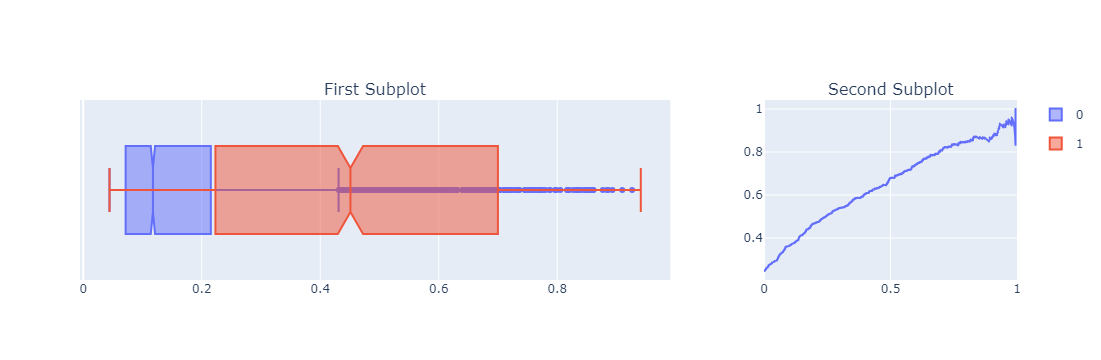

In [14]:
from plotly.subplots import make_subplots
self = current_learner
fig = make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3],
                    subplot_titles=("First Subplot","Second Subplot"))

tmpdict = {
    'proba' : self.proba[:,1],
    'label' : self.label
}
tmpdf = pd.DataFrame.from_dict(tmpdict)
tf = px.box(tmpdf, color='label', x='proba', notched=True, points='outliers',category_orders={'label':[0,1]})

fig.add_traces(tf.data, cols=1, rows=1)
# fig.add_trace(tf.data[1], col=1, row=1)

p, r, t = precision_recall_curve(self.label, self.proba[:,1], pos_label=1)
tmpdict = {
    '1-Recall' : 1-r,
    'Precision' : p,
}
tmpdf = pd.DataFrame.from_dict(tmpdict)
tf = px.line(tmpdf, x='1-Recall', y='Precision')

fig.add_trace(tf.data[0], col=2, row=1)
fig.add_trace(g
fig.show()